In [17]:
#imports
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class Game():
    # Player 0 choses rows, 1 choses column
    def __init__(self, number_actions,number_players,data=[]):
        self.number_players=number_players
        self.data = data
        self.number_actions=number_actions
        
    def get_data_player(self, player):
        return self.data[player]

    def get_number_players(self):
        return self.number_players

    def get_number_actions(self):
        return self.number_actions
    
    def get_payoff(self,player_num,players_actions):
        payoffs = self.get_data_player(player_num)
        idx = 0
        for i in range(self.number_players):
            idx+=players_actions[i]*(self.number_players-1)**(self.number_players-i-1)
        return payoffs[idx]
    def update_game(self, actions=None):
    # Iterates the game and change the matrix. Not sure if we will need to use this? I think the matrices are fixed over time.
        pass


# 3 player game 
tree1 = [    1, 2,-1, 2,-1,   1,-1,-1]
tree2 = [ -0.5,-1, 2,-1,-1,-0.5, 2,-1]
tree3 = [ -0.5,-1,-1,-1,2,-0.5,-1, 2]
#tree3 = [0,1,2,3,4,5,6,7]

testing_game = np.array([tree1,tree2,tree3])
testing_game = Game(2,3,testing_game)

actions = [0,1,1]
testing_game.get_payoff(2,actions)

-1.0

In [19]:
class FictitiousPlayer:
    
    def __init__(self,player_num,game):
        self.empirical = [np.ones(game.get_number_actions()) for i in range(game.get_number_players())]
        self.player_num=player_num
        self.returns = np.array([0])
        self.game=game
        self.last_decision=0


    def get_action_slices_for_player(self,player):
        """
        Receives the number of the player we are interested in, and returns a list of selection tuples (True,False,True,True...etc)
        The selection tuples select which payoffs are connect to a certain player decision.
        Example:
                 o        - player 0
               /   \
             o       o    - player 1
            / \     / \
          o    o    o   o - player 2
         / \  / \  / \ / \
         0 1  2 3  4 5 6 7

        Input:0, output = [ (0,1,2,3), (4,5,6,7)] as selection tuples.
        Input:1, output = [ (0,1,4,5), (2,3,6,7)] as selection tuples.
        Input:2, output = [ (0,2,4,6), (1,3,5,7)] as selection tuples.
        """
        payoffs = self.game.get_data_player(self.player_num)
        selection_array = np.arange(len(payoffs))
        result=[]
        nactions = self.game.get_number_actions()
        div = nactions**( self.game.get_number_players()-player-1)

        for action in range(self.game.get_number_actions()):
            selection = np.asarray(selection_array//div%nactions==action)
            result.append(selection)

        return result

    def play(self):# Receive game matrix for this player only.
        payoffs = self.game.get_data_player(self.player_num).copy()
        #Compute, for each row, the expected payoff based on the probability of other players playing
        for player in range(self.game.get_number_players()):
            if player==self.player_num:
                continue
            else:
                action_slices = self.get_action_slices_for_player(player)
                for action in range(self.game.get_number_actions()):
                    payoffs[action_slices[action]]*= self.empirical[player][action]

        action_slices = self.get_action_slices_for_player(self.player_num)
        expected_payoffs =[ payoffs[action_slices[action]].sum() for action in range(self.game.get_number_actions())] 
        self.last_decision= np.argmax(expected_payoffs)
        return  
        
    
    def update(self, players_actions):
        self.returns = np.append(self.returns, self.game.get_payoff(self.player_num,players_actions) )
        # Updates empirical with player actions
        for i in range(len(players_actions)):
            self.empirical[i] += players_actions[i]

# Debugging
asd = FictitiousPlayer(2,testing_game)
asd.get_action_slices_for_player(2)
asd.play()

## Simple analysis for 1st part of the presentation 

In [20]:
class RandomPlayer:
    """
    Receives a mixed strategy [p1,p2,p3...pn] for a set of N strategies, and returns a random number based on these probabilities.
    """
    def __init__(self,matrix,probabilities):
        self.p = np.array(probabilities)
        self.p = self.p/np.sum(self.p)
        self.nb_actions=len(self.p)
        self.matrix=matrix
        self.returns = np.array([0])
        self.last_decision=None

    def decision(self,T=345345):
        self.last_decision = np.random.choice(self.nb_actions, p = self.p)
        return self.last_decision
    
    def update(self,otheraction):
        self.returns= np.append(self.returns,self.matrix.transpose()[otheraction].transpose())

In [107]:
class RegretMatchingPlayer:
    def __init__(self,matrix):
        self.number_actions = len(matrix)
        self.p = np.ones(self.number_actions)
        self.p = [self.p/sum(self.p)]
        self.matrix=matrix
        self.decisions=[]
        self.returns = np.array([0])
        self.cumulative_regrets = np.zeros(shape=self.number_actions)
        self.strategy_sum = np.zeros(shape=self.number_actions)
        self.own_plays=np.zeros(len(matrix))
        self.average = [np.ones(self.number_actions)/sum(np.ones(self.number_actions))]

    def decision(self,T=-1):
    
        self.decisions.append(np.random.choice(self.number_actions, p = self.p[T]))
        return self.decisions[T]

    def get_payoff(self,own_decision: int, other_action: int) -> int:
        return self.matrix.transpose()[own_decision].transpose()[other_action]
    
    def get_regrets(self,payoff,opp_action):
        return np.array( [self.get_payoff(our_action, opp_action) - payoff for our_action in range(self.number_actions)] )
            
    def update(self,other_action):
        our_payoff = self.get_payoff(self.decisions[-1], other_action)
        regrets = self.get_regrets(our_payoff, other_action)
        self.cumulative_regrets += regrets
        pos_cumulative_regrets=np.maximum(0,self.cumulative_regrets)
        next_prob = self.p[-1].copy()
        
        if np.sum(pos_cumulative_regrets)>0:
            next_prob=pos_cumulative_regrets/np.sum(pos_cumulative_regrets)
        else:
            for k in range(self.number_actions):
                next_prob[k]=1/self.number_actions

        self.p.append(next_prob)
        self.own_plays[self.decisions[-1]]+=1
        self.average.append(self.own_plays/np.sum(self.own_plays))
        self.returns = np.append(self.returns, our_payoff )

    

In [22]:
class FictitiousPlayer:
    def __init__(self,matrix):
        self.empirical = np.zeros(len(matrix))
        self.matrix = matrix
        self.returns = np.array([0])
        self.last_decision=None
        first_decision=self.decision()

        self.average = [np.zeros(len(matrix))]
        self.average[0][first_decision]=1
        self.own_plays=np.zeros(len(matrix))

    def decision(self):
        #Compute, for each row, the expected payoff based on the probability of other players playing
        payoffs = np.matmul(self.empirical, self.matrix.transpose())
        self.last_decision=np.argmax(payoffs)
        return  self.last_decision
        
    
    def update(self, player_action ):
        possible_plays = self.matrix.transpose()[player_action].transpose()
        returned = possible_plays[self.last_decision]
        self.own_plays[self.last_decision]+=1
        self.average.append(self.own_plays/np.sum(self.own_plays))
        self.returns = np.append(self.returns, returned )
        self.empirical[player_action] += 1

In [57]:
'''class WeightsPlayer:
    def __init__(self,matrix):
        self.number_actions = len(matrix)
        self.p = np.ones(self.number_actions)
        self.p = [self.p/sum(self.p)]
        self.decisions = []
        self.matrix=matrix
        self.returns = np.array([0])

    def decision(self,T=-1):
        self.decisions.append(np.random.choice(self.number_actions, p = self.p[T]))
        return self.decisions[T]

    def update(self,player2_action,T=234234):
        LEARNING_RATE=0.01
        next_prob = self.p[-1].copy()

        for k in range(len(next_prob)):
            cost = -self.matrix.transpose()[player2_action].transpose()[k]
            next_prob[k]*=1-cost*LEARNING_RATE

        self.p.append(next_prob/np.sum(next_prob))
        self.returns= np.append(self.returns,self.matrix.transpose()[player2_action].transpose()[self.decisions[-1]])'''

class WeightsPlayer:
    def __init__(self,matrix):
        self.number_actions = len(matrix)
        self.p = np.ones(self.number_actions)
        self.p = [self.p/sum(self.p)]
        self.decisions = []
        self.matrix=np.array(matrix,dtype='float64')
        self.returns = np.array([0])
        #self.matrix /= np.max(np.abs(self.matrix))
        #self.matrix *= (1/self.matrix.)
        self.average = [np.zeros(len(matrix))]
        self.own_plays=np.zeros(len(matrix))

        

    def decision(self,T=-1):
        self.decisions.append(np.random.choice(self.number_actions, p = self.p[T]))
        return self.decisions[T]

    def update(self,player2_action,T=234234):
        LEARNING_RATE=0.05
        next_prob = self.p[-1].copy()
        for k in range(len(next_prob)):
            cost = -self.matrix.transpose()[k].transpose()[player2_action]
            next_prob[k]*=1 -LEARNING_RATE*cost
        
        self.p.append(next_prob/np.sum(next_prob))
        self.returns= np.append(self.returns,self.matrix.transpose()[self.decisions[-1]].transpose()[player2_action])

        self.own_plays[self.decisions[-1]]+=1
        self.average.append(self.own_plays/np.sum(self.own_plays))


In [75]:
prisonner_dilemna_matrix = np.array([[[3, 0], 
                                    [5, 1]],
                                   [[3, 5],
                                   [0, 1]]])
prisonner_dilemna_matrix


A=1
B=1
C=1

rock_paper_scisors = np.array([[    [ 0, -A, B], 
                                    [ A, 0, -C],
                                    [ -B, C, 0]],
                                   [[ 0, A,-B], 
                                    [-A, 0, C],
                                    [ B,-C, 0]] ])

rock_paper_scisors+=1

matching_pennies = np.array([[[1, -1], 
                                    [-1, 1]],
                                   [[-1, 1],
                                   [1, -1]]])

#matching_pennies+=2

A=-2
B=-3
C=-5
D=-6


road_game  = np.array([[[ C, A], 
                                        [  B, D]],
                                        [ [C, B],
                                          [ A, D]]])

road_game+=6

In [76]:
road_game

array([[[1, 4],
        [3, 0]],

       [[1, 3],
        [4, 0]]])

In [125]:
def Game(matrix,iterations=10000):

    p1 = WeightsPlayer(matrix[0])
    #p1 = RegretMatchingPlayer(matrix[0])
    #p1 = FictitiousPlayer(matrix[0])
    #p1 = RandomPlayer(matrix,random_strategy)

    random_strategy=[2,2]
    #p2 = RegretMatchingPlayer(matrix[1].transpose())
    p2 = RandomPlayer(matrix,random_strategy)
    #p2 = FictitiousPlayer(matrix[1].transpose())
    #p2 = WeightsPlayer(matrix[1].transpose())

    for a in range(iterations):

        #decisions
        decision1 = p1.decision()
        decision2 = p2.decision()
        
        #updates
        p1.update(decision2)
        p2.update(decision1)
    
    return (p1,p2)

In [126]:
prisonner_dilemna_matrix

array([[[3, 0],
        [5, 1]],

       [[3, 5],
        [0, 1]]])

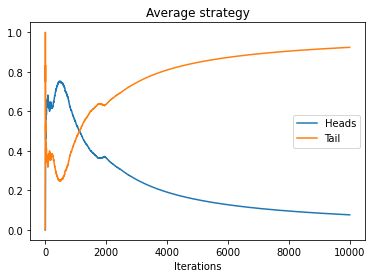

In [129]:
p,p2 = Game(matching_pennies)

plt.plot(p.average)
plt.title('Average strategy')
plt.xlabel('Iterations')


#plt.legend(['Rock', 'Paper', 'Scissors'])
plt.legend(['Heads', 'Tail'])
#plt.legend(['Silence', 'Confess'])
#plt.legend(['Road A', 'Road B'])

plt.show()

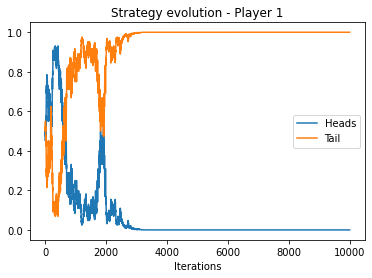

In [130]:
plt.plot(p.p)
plt.title('Strategy evolution - Player 1')
plt.xlabel('Iterations')


#plt.legend(['Rock', 'Paper', 'Scissors'])
plt.legend(['Heads', 'Tail'])
#plt.legend(['Silence', 'Confess'])
#plt.legend(['Road A', 'Road B'])

plt.show()

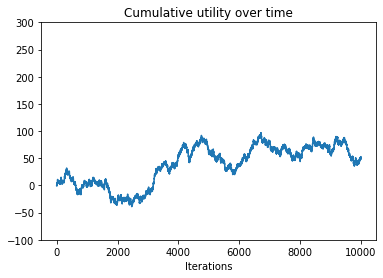

In [131]:
plt.plot(p.returns.cumsum())
plt.title('Cumulative utility over time')
plt.xlabel('Iterations')
plt.gca().set_ylim([-100, 300])

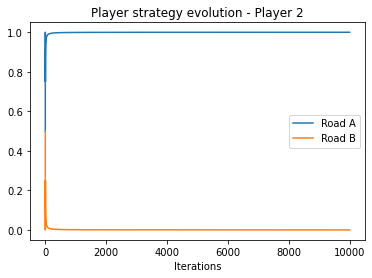

In [31]:
plt.plot(p2.average)
plt.title('Player strategy evolution - Player 2')

plt.xlabel('Iterations')

#plt.legend(['Rock', 'Paper', 'Scissors'])
#plt.legend(['Heads', 'Tail'])
#plt.legend(['Silence', 'Confess'])
plt.legend(['Road A', 'Road B'])

plt.show()

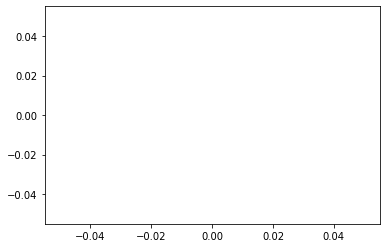

In [32]:
plt.plot(p2.returns.cumsum())